# To import all neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import fontconfig_pattern,font_manager
%matplotlib inline

# To read in our chats

I'll open the chat as a text file and save it as "chat"

In [2]:
with open("WhatsApp Chat.txt", encoding = "utf-8") as text:
    chat = text.read()

# A little cleaning

Now, I'm going to clean up the chats and save it as a dataframe.
I'll start by selecting all messages. The messages follow the pattern (date, time - sender: message), which is what I'm going to search for, select and save in a list. 

In [3]:
pattern = re.compile(r"(\d+/\d+/\d+,\s+\d+:\d+\s-\s\w+:\s+.+[\n+\D+]+)")
messages = re.findall(pattern, chat)

I'll define two functions to clean and split the messages into "Datetime", "Sender", and "Message" and then use them. Afterwards, I'll put the messages in a pandas dataframe.

In [4]:
# Function to clean messages by replacing newlines with spaces
def clean(text):
    return text.replace("\n", " ")

# Function to split the messages into "Datetime", "Sender", and "Messages"    
def split(text):
    first_split = re.split("\s-\s", text)
    second_split = [first_split[0].strip(",")]+first_split[1].split(": ")
    return second_split

# Mapping the two functions to messages
messages = list(map(clean, messages))
messages= list(map(split, messages))

columns = ["Datetime", "Sender", "Message"] # This will be the column names for the dataframe

# Creating the Dataframe
chat_frame = pd.DataFrame(data = messages)[[0,1,2]]
chat_frame.columns = columns
chat_frame["Datetime"] = pd.to_datetime(chat_frame["Datetime"]) # This will convert the "Datetime" column to pandas datetime

chat_frame.head()

,Datetime,Sender,Message
0,2017-11-05 20:41:00,Dotshine,👀
1,2017-12-11 20:35:00,Hadek,Hello
2,2017-12-11 20:36:00,Dotshine,👀👀👀
3,2017-12-11 20:46:00,Hadek,What is with the eye
4,2017-12-11 20:48:00,Dotshine,Checking to see if it's really you


In [5]:
chat_frame.tail()

,Datetime,Sender,Message
26812,2020-06-25 20:48:00,Hadek,Hello
26813,2020-06-25 20:48:00,Hadek,Have precious reply your messages She was on...
26814,2020-06-25 22:31:00,Hadek,Has*
26815,2020-06-26 02:11:00,Dotshine,"Oh, yeah"
26816,2020-06-26 02:11:00,Dotshine,Thanks


In [6]:
chat_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26817 entries, 0 to 26816
Data columns (total 3 columns):
Datetime    26817 non-null datetime64[ns]
Sender      26817 non-null object
Message     26817 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 628.6+ KB


In [7]:
chat_frame_or = chat_frame.copy()
chat_frame = chat_frame[chat_frame["Message"]!="<Media omitted> "]
chat_frame = chat_frame[chat_frame["Message"]!="This message was deleted "]
chat_frame.head()

,Datetime,Sender,Message
0,2017-11-05 20:41:00,Dotshine,👀
1,2017-12-11 20:35:00,Hadek,Hello
2,2017-12-11 20:36:00,Dotshine,👀👀👀
3,2017-12-11 20:46:00,Hadek,What is with the eye
4,2017-12-11 20:48:00,Dotshine,Checking to see if it's really you


In [8]:
chat_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26375 entries, 0 to 26816
Data columns (total 3 columns):
Datetime    26375 non-null datetime64[ns]
Sender      26375 non-null object
Message     26375 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 824.2+ KB


I'll now create an emoji column to contain emojis used in messages. I'll also tokenize the messages and remove stopwords

In [9]:
emoji_dict = {i:j for i,j in emoji.UNICODE_EMOJI.items() if "skin_tone" not in j and "male_sign" not in j}

# Function to select emojis in a message and save them as numpy array (emoji with skin color and gender sign are excluded)
def choose_emoji(sentence):
    return np.array([i for i in sentence if i in emoji_dict])

# Function to tokenize message and remove stopwords and punctuation
def remove_stopwords(sentence):
    stopwords = nltk.corpus.stopwords
    sentence= nltk.tokenize.wordpunct_tokenize(sentence)
    return np.array([i.lower() for i in sentence if i.lower() not in stopwords.words('english') if i.lower().isalpha() if (len(i) > 1)])

# To create an emoji column and tokenize the messages and save them as numpy array
chat_frame["Emoji"] = chat_frame["Message"].apply(choose_emoji)
chat_frame["Message"] = chat_frame["Message"].apply(remove_stopwords)

chat_frame.head()

,Datetime,Sender,Message,Emoji
0,2017-11-05 20:41:00,Dotshine,[],[👀]
1,2017-12-11 20:35:00,Hadek,[hello],[]
2,2017-12-11 20:36:00,Dotshine,[],"[👀, 👀, 👀]"
3,2017-12-11 20:46:00,Hadek,[eye],[]
4,2017-12-11 20:48:00,Dotshine,"[checking, see, really]",[]


In [10]:
chat_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26375 entries, 0 to 26816
Data columns (total 4 columns):
Datetime    26375 non-null datetime64[ns]
Sender      26375 non-null object
Message     26375 non-null object
Emoji       26375 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.0+ MB


Now, I'll break the chat into two groups based on the sender of the messages

In [11]:
#Let's group the chat by "Sender"
bysender = chat_frame.groupby("Sender")

# Saving each group into a variable
my_messages = bysender.get_group("Dotshine")
hadek_messages = bysender.get_group("Hadek")

In [12]:
my_messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12134 entries, 0 to 26816
Data columns (total 4 columns):
Datetime    12134 non-null datetime64[ns]
Sender      12134 non-null object
Message     12134 non-null object
Emoji       12134 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 474.0+ KB


In [13]:
hadek_messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14241 entries, 1 to 26814
Data columns (total 4 columns):
Datetime    14241 non-null datetime64[ns]
Sender      14241 non-null object
Message     14241 non-null object
Emoji       14241 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 556.3+ KB


### Removing empty chats
Since I've removed stopwords, there will probably be some messages that are empty. So, I'm going to remove those messages. I'll start by replacing all empty list with NaN, then I'll drop rows that has no message or emoji.

In [14]:
# Function to replace empty list with NaN
def delete_empty_chats(message:list):
    if (len(message) == 0): return np.nan
    else:return message

# Creating a copy of the dataframes
my_useful_messages = my_messages.copy()
hadek_useful_messages = hadek_messages.copy()

# Applying the function to the dataframes
my_useful_messages["Message"] = my_useful_messages["Message"].apply(delete_empty_chats)
my_useful_messages["Emoji"] = my_useful_messages["Emoji"].apply(delete_empty_chats)

hadek_useful_messages["Message"] = hadek_useful_messages["Message"].apply(delete_empty_chats)
hadek_useful_messages["Emoji"] = hadek_useful_messages["Emoji"].apply(delete_empty_chats)

In [15]:
my_useful_messages.head()

,Datetime,Sender,Message,Emoji
0,2017-11-05 20:41:00,Dotshine,NaN,[👀]
2,2017-12-11 20:36:00,Dotshine,NaN,"[👀, 👀, 👀]"
4,2017-12-11 20:48:00,Dotshine,"[checking, see, really]",NaN
6,2017-12-11 20:49:00,Dotshine,[yes],NaN
7,2017-12-11 20:49:00,Dotshine,"[bought, new]",[📱]


In [16]:
hadek_useful_messages.head()

,Datetime,Sender,Message,Emoji
1,2017-12-11 20:35:00,Hadek,[hello],NaN
3,2017-12-11 20:46:00,Hadek,[eye],NaN
5,2017-12-11 20:49:00,Hadek,"[av, finish, checking]",NaN
8,2017-12-11 20:54:00,Hadek,NaN,NaN
9,2017-12-11 20:54:00,Hadek,"[still, waiting, buy]",NaN


In [17]:
my_useful_messages.dropna(subset=["Message", "Emoji"], how = "all", inplace = True)

hadek_useful_messages.dropna(subset=["Message", "Emoji"], how = "all", inplace = True)

In [18]:
my_useful_messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11447 entries, 0 to 26816
Data columns (total 4 columns):
Datetime    11447 non-null datetime64[ns]
Sender      11447 non-null object
Message     10695 non-null object
Emoji       3393 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 447.1+ KB


In [19]:
hadek_useful_messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13095 entries, 1 to 26813
Data columns (total 4 columns):
Datetime    13095 non-null datetime64[ns]
Sender      13095 non-null object
Message     12019 non-null object
Emoji       1513 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 511.5+ KB


## Let's start the analysis
The first thing I'm going to do is count the number of times each word was used.

In [20]:
my_word_count = pd.Series(np.concatenate(list(my_useful_messages["Message"].dropna()))).value_counts().rename_axis('Word').reset_index(name='frequency').sort_values(by = "frequency", ascending = False)
hadek_word_count = pd.Series(np.concatenate(list(hadek_useful_messages["Message"].dropna()))).value_counts().rename_axis('Word').reset_index(name='frequency').sort_values(by = "frequency", ascending = False)

print("Total number of words used by both of us is %i, made up of %i unique words" %(my_word_count["frequency"].sum()+hadek_word_count["frequency"].sum(), len(set(my_word_count["Word"]).union(set(hadek_word_count["Word"])))))
print("Total number of words used by me is %i, made up of %i unique words" %(my_word_count["frequency"].sum(), len(my_word_count["Word"])))
print("Total number of words used by Hadek is %i, made up of %i unique words" %(hadek_word_count["frequency"].sum(), len(hadek_word_count["Word"])))
print("\n\nMy word count info\n")
print(my_word_count.info())
print("\n\nHadek's word count info\n")
print(hadek_word_count.info())

Total number of words used by both of us is 49419, made up of 4872 unique words
Total number of words used by me is 23563, made up of 3510 unique words
Total number of words used by Hadek is 25856, made up of 3319 unique words


My word count info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3510 entries, 0 to 3509
Data columns (total 2 columns):
Word         3510 non-null object
frequency    3510 non-null int64
dtypes: int64(1), object(1)
memory usage: 82.3+ KB
None


Hadek's word count info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3319 entries, 0 to 3318
Data columns (total 2 columns):
Word         3319 non-null object
frequency    3319 non-null int64
dtypes: int64(1), object(1)
memory usage: 77.8+ KB
None


#### Let's see my top 10 most used words

In [21]:
my_word_count.head(10)

,Word,frequency
0,know,459
1,ok,447
2,want,288
3,like,285
4,na,259
5,good,255
6,yes,252
7,ni,236
8,say,221
9,think,220


#### And Hadek's top 10 most used words are...

In [22]:
hadek_word_count.head(10)

,Word,frequency
0,okay,975
1,know,578
2,yes,494
3,good,418
4,like,229
5,want,227
6,say,225
7,one,211
8,ok,205
9,really,198


Apparently, she likes "okay" a lot. A friend suggested most females do that, but I don't have the data to make such claims.

In [23]:
my_word_count[my_word_count["Word"] == "lol"]

,Word,frequency
151,lol,30


Recently, I used "lol" in a message I sent to Hadek and she claimed that I rarely use it. Turns out she was right. I've only used "lol" 30 times in almost 3 years of chatting with her.

### Histogram showing how often I use words

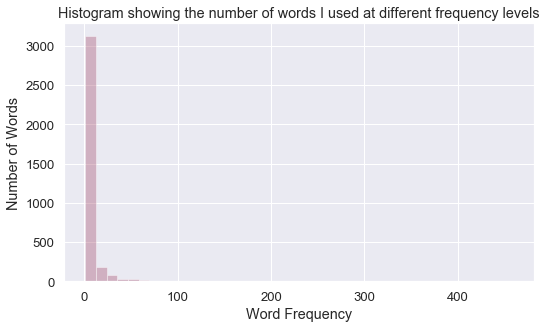

In [24]:
sns.set(style = "darkgrid", context = "notebook", font_scale = 1.2)
sns.distplot(my_word_count["frequency"], bins = 40, kde = False, color = "#aa5a79", rug= False, axlabel = "Word Frequency").set_ylabel("Number of Words")
plt.title("Histogram showing the number of words I used at different frequency levels")
plt.tight_layout(rect = (0,0,1.5,1.2))

plt.savefig("Histogram showing the number of words I used at different frequency levels.png", format = "png", bbox_inches = "tight")
plt.show()

Turns out over 3000 of the 3512 words I've used have only been used less than 11 times. Shows I love sticking to some words.

### Histogram showing how often Hadek uses words

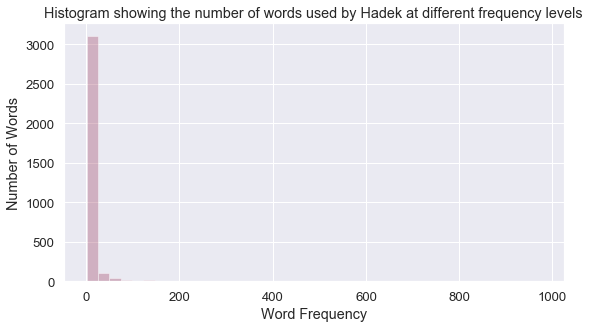

In [25]:
sns.set(style = "darkgrid", context = "notebook", font_scale = 1.2)
sns.distplot(hadek_word_count["frequency"], bins = 40, kde = False, color = "#aa5a79", rug= False, axlabel = "Word Frequency").set_ylabel("Number of Words")
plt.title("Histogram showing the number of words used by Hadek at different frequency levels")
plt.tight_layout(rect = (0,0,1.7,1.2))

plt.savefig("Histogram showing the number of words used by Hadek at different frequency levels.png", format = "png", bbox_inches = "tight")
plt.show()

Just like me, over 3000 words used by Hadek have only been used less than 11 times

### To plot bar charts showing our top ten most used words
Let's plot the top 10 most used words.

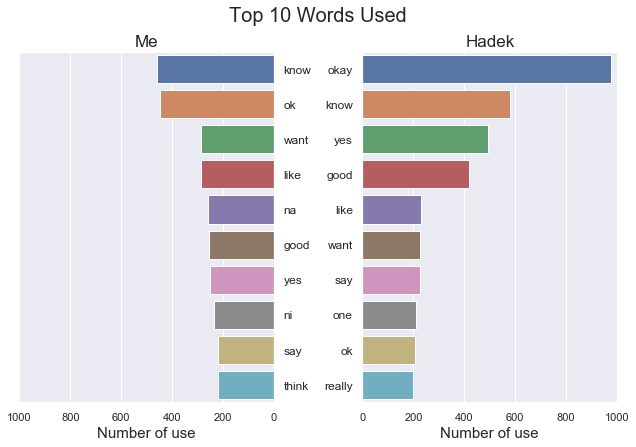

In [26]:
sns.set( font_scale = 1)

fig, chart = plt.subplots(ncols = 2, sharey = False)#, figsize = (8,10))
sns.set(style = "whitegrid")

sns.barplot(ax = chart[0], orient = "horizontal", x = "frequency", y = "Word", data = my_word_count.iloc[:10])
sns.barplot(ax = chart[1], orient = "horizontal", x = "frequency", y = "Word", data = hadek_word_count.iloc[:10])

chart[0].set(xlim = (0,1000))
chart[1].set(xlim = (0,1000))

chart[0].set_yticklabels(chart[0].get_yticklabels(), fontsize = 12)
chart[1].set_yticklabels(chart[1].get_yticklabels(), fontsize = 12)

chart[1].set_ylabel("")
chart[0].set_ylabel("")

chart[1].set_xlabel("Number of use", fontsize = 15)
chart[0].set_xlabel("Number of use", fontsize = 15)

chart[0].yaxis.tick_right()
chart[0].invert_xaxis()

chart[0].set_title("Me", fontsize = 17)
chart[1].set_title("Hadek", fontsize = 17)

chart[0].tick_params(axis = "y", which = "both", left = False, right = False)



plt.tight_layout(rect = (0,0,1.5,1.5))
plt.suptitle("Top 10 Words Used", x = 0.75, y =1.55, fontsize = 20)

plt.savefig("Top 10 Words Used.png", format = "png", bbox_inches = "tight")
plt.show()

### What do emojis have to say?
I'll create a dataframe for emoji count just like i did for words

In [27]:
my_emoji_count = pd.Series(np.concatenate(list(my_useful_messages["Emoji"].dropna()))).value_counts().rename_axis('Emoji').reset_index(name='frequency').sort_values(by = "frequency", ascending = False)

hadek_emoji_count = pd.Series(np.concatenate(list(hadek_useful_messages["Emoji"].dropna()))).value_counts().rename_axis('Emoji').reset_index(name='frequency').sort_values(by = "frequency", ascending = False)

#### Let's see my top 10 emojis
I'm pretty sure my most used emoji is the new moon face

In [28]:
my_emoji_count.head(10)

,Emoji,frequency
0,🌚,1239
1,🙄,446
2,😒,392
3,😏,382
4,😂,275
5,🤷,182
6,😁,104
7,🤦,75
8,😑,63
9,🚶,61


And I'm right, my most used emoji is the new moon face. The numbers clearly show how much I like this emoji.

#### And here is Hadek's top 10

In [29]:
hadek_emoji_count.head(10)

,Emoji,frequency
0,🌝,588
1,😏,439
2,🙄,381
3,🌚,189
4,🤣,169
5,🤔,154
6,😳,134
7,😜,106
8,🚶,102
9,😁,98


Hadek most used emoji seems to be the full moon face.Maybe it's because I use the new moon face a lot.

In [30]:
print ("We both used %i unique emojis" %(len(my_emoji_count.merge(hadek_emoji_count, on = "Emoji", how = "outer").fillna(0))))
print (f"I used emojis {my_emoji_count['frequency'].sum()} times. This includes {len(my_emoji_count)} different emojis.\nOn the other hand, Hadek used emojis {hadek_emoji_count['frequency'].sum()} times which includes {len(hadek_emoji_count)} different emojis.")

We both used 136 unique emojis
I used emojis 3756 times. This includes 83 different emojis.
On the other hand, Hadek used emojis 3575 times which includes 108 different emojis.


Though Hadek used more varieties of emojis, turns out I used emojis more than she did.

### To plot bar charts showing all the emojis we used
I'll start by merging the two emoji counts into a dataframe, and then plotting all the emojis using the dataframe.

In [31]:
# Let's put the two emoji counts in one dataframe for comparison
our_emoji_count = my_emoji_count.merge(hadek_emoji_count, on = "Emoji", how = "outer").fillna(0)

our_emoji_count.columns =['Emoji', 'frequency_me', 'frequency_hadek']

our_emoji_count.head()

,Emoji,frequency_me,frequency_hadek
0,🌚,1239.0,189.0
1,🙄,446.0,381.0
2,😒,392.0,26.0
3,😏,382.0,439.0
4,😂,275.0,0.0


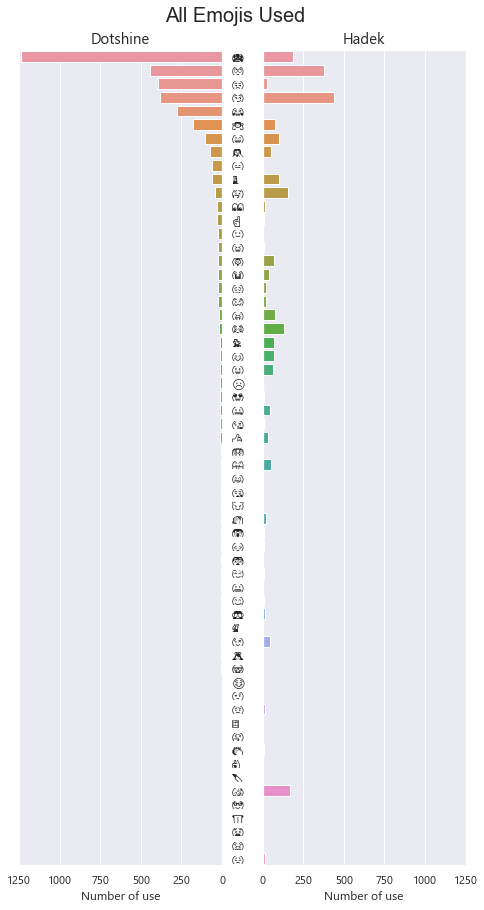

In [32]:
sns.set(font = "Segoe UI Emoji", font_scale = 1)
labels = list(our_emoji_count["Emoji"])
fig, chart = plt.subplots(ncols = 2, sharey = True, figsize = (8,15))
sns.set(style = "whitegrid")

sns.barplot(ax = chart[0], orient = "horizontal", x = "frequency_me", y = "Emoji", data = our_emoji_count.iloc[:60])
sns.barplot(ax = chart[1], orient = "horizontal", x = "frequency_hadek", y = "Emoji", data = our_emoji_count[:60])

chart[0].yaxis.tick_right()
chart[0].set(xlim = (0,1250))
chart[1].set(xlim = (0,1250))
chart[0].invert_xaxis()
chart[0].set_yticklabels(chart[0].get_yticklabels(), fontsize = 10)
chart[1].set_ylabel("")
chart[0].set_ylabel("")

chart[1].set_xlabel("Number of use")
chart[0].set_xlabel("Number of use")

chart[0].tick_params(axis = "y", which = "both", left = False, right = False)

chart[0].set_title("Dotshine", fontsize = 15)
chart[1].set_title("Hadek", fontsize = 15)

plt.suptitle("All Emojis Used", y=0.92, fontsize = 20)
plt.savefig("our_emoji_use.png", bbox_inches = "tight", dpi = 1000)
plt.show()


### Plot the top ten emoji used by both of us
Let's see the top 10 emojis used by the two of us

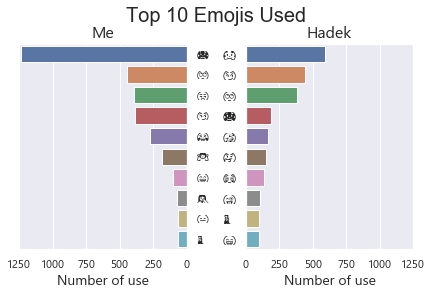

In [33]:
sns.set(font = "Segoe UI Emoji", font_scale = 1)
labels = list(our_emoji_count["Emoji"])

fig, chart = plt.subplots(ncols = 2, sharey = False)#, figsize = (8,10))
sns.set(style = "whitegrid")

sns.barplot(ax = chart[0], orient = "horizontal", x = "frequency", y = "Emoji", data = my_emoji_count.iloc[:10])
sns.barplot(ax = chart[1], orient = "horizontal", x = "frequency", y = "Emoji", data = hadek_emoji_count[:10])

chart[0].yaxis.tick_right()
chart[0].set(xlim = (0,1250))
chart[1].set(xlim = (0,1250))
chart[0].invert_xaxis()
chart[0].set_yticklabels(chart[0].get_yticklabels(), fontsize = 10)

chart[1].set_ylabel("")
chart[0].set_ylabel("")

chart[1].set_xlabel("Number of use", fontsize = 14)
chart[0].set_xlabel("Number of use", fontsize = 14)

chart[0].set_title("Me", fontsize = 16)
chart[1].set_title("Hadek", fontsize = 16)
chart[0].tick_params(axis = "y", which = "both", left = False, right = False)

plt.suptitle("Top 10 Emojis Used", y =1.02, fontsize = 20)
plt.tight_layout()

plt.savefig("Top 10 Emojis Used.png", format = "png", bbox_inches = "tight")
plt.show()

In [34]:
chat_frame["Date"] = chat_frame["Datetime"].apply(lambda x: x.date())

chat_by_date = chat_frame.groupby("Date")

### To get the number of days of active chats

In [35]:
len(chat_by_date.groups.keys())

552

### To get the range of our chats in days

In [36]:
chat_days_range = list(chat_by_date.groups.keys())[-1] - list(chat_by_date.groups.keys())[0]
chat_days_range.days

964

Apparently, out of 964 days between 2017-11-05 and 2020-06-26, we only sent texts on 552 of those days. Thats just about 57%.

### Who usually texts first?
Let's see who texted first the most. 
I'm going to group the chats by date and then form a new dataframe with the first message in each group.

In [37]:
first_chats = []
for i in chat_by_date.groups.keys():
    first_chats.append(chat_by_date.get_group(i).iloc[0])

first_chats_by_dates = pd.DataFrame(data = first_chats).reset_index(drop = True)

first_chats_by_dates.head()

,Datetime,Sender,Message,Emoji,Date
0,2017-11-05 20:41:00,Dotshine,[],[👀],2017-11-05
1,2017-12-11 20:35:00,Hadek,[hello],[],2017-12-11
2,2017-12-12 13:51:00,Hadek,"[wait, nd]",[],2017-12-12
3,2017-12-13 07:43:00,Dotshine,[gboun],[],2017-12-13
4,2017-12-16 11:04:00,Dotshine,[shu],[],2017-12-16


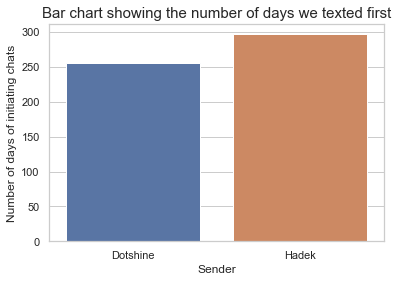

In [38]:
sns.countplot(x= "Sender", data = first_chats_by_dates)
plt.ylabel("Number of days of initiating chats")
plt.title("Bar chart showing the number of days we texted first", fontsize = 15)

plt.savefig("Bar chart showing the number of days we texted first.png", bbox_inches = "tight", dpi = 200)
plt.show()

### Who texts last?
Let's see who texts last. 
I'm going to group the chats by date and then form a new dataframe with the last message in each group.

In [39]:
last_chats = []
for i in chat_by_date.groups.keys():
    last_chats.append(chat_by_date.get_group(i).iloc[-1])

last_chats_by_dates = pd.DataFrame(data = last_chats).reset_index(drop = True)

last_chats_by_dates.head()

,Datetime,Sender,Message,Emoji,Date
0,2017-11-05 20:41:00,Dotshine,[],[👀],2017-11-05
1,2017-12-11 22:59:00,Dotshine,[doubt],[],2017-12-11
2,2017-12-12 22:47:00,Hadek,[jebi],[],2017-12-12
3,2017-12-13 07:43:00,Dotshine,[gboun],[],2017-12-13
4,2017-12-16 23:03:00,Hadek,[gud],[],2017-12-16


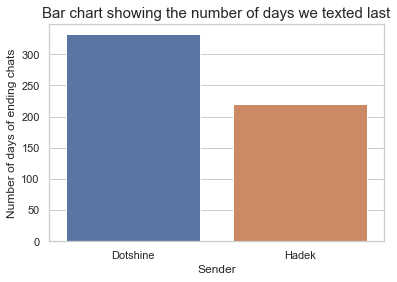

In [40]:
sns.countplot(x= "Sender", data = last_chats_by_dates)
plt.ylabel("Number of days of ending chats")
plt.title("Bar chart showing the number of days we texted last", fontsize = 15)

plt.savefig("Bar chart showing the number of days we texted last.png", bbox_inches = "tight", dpi = 200)
plt.show()

Turns out she texts first more than I do, which may be because I text last a lot.

### How quickly do we respond?
Let's check our average response time.

In [41]:
my_response_time = pd.Timedelta(0)
no_of_times_responded = 0
for i in chat_by_date.groups.keys():
    temp = chat_by_date.get_group(i).copy().reset_index(drop = True)
    temp2 = temp.loc[[0]].append(temp).reset_index(drop = True).drop(index = len(temp))
    new_temp = temp[temp["Sender"].apply(lambda x: x == "Dotshine").all()==(temp["Sender"] != temp2["Sender"])]
    new_temp2 = temp2[temp["Sender"].apply(lambda x: x == "Dotshine").all()==(temp["Sender"] != temp2["Sender"])]
    my_response_time += (new_temp["Datetime"]-new_temp2["Datetime"]).sum()
    if not len(new_temp2)== len(new_temp)==0: no_of_times_responded +=1
        
print (f"My total response time = {my_response_time}\nNumber of times responded = {no_of_times_responded}")
    
my_avg_resp_time = my_response_time/no_of_times_responded
print(f"My average response time is {my_avg_resp_time}")

My total response time = 29 days 05:22:00
Number of times responded = 535
My average response time is 0 days 01:18:39.476635


In [42]:
hadek_response_time = pd.Timedelta(0)
hadek_no_of_times_responded = 0
for i in chat_by_date.groups.keys():
    temp = chat_by_date.get_group(i).copy().reset_index(drop = True)
    temp2 = temp.loc[[0]].append(temp).reset_index(drop = True).drop(index = len(temp))
    new_temp = temp[temp["Sender"].apply(lambda x: x == "Hadek").all()==temp["Sender"].apply(lambda x: x == "Hadek").all()==(temp["Sender"] != temp2["Sender"])]
    new_temp2 = temp2[temp["Sender"].apply(lambda x: x == "Hadek").all()==(temp["Sender"] != temp2["Sender"])]
    hadek_response_time += (new_temp["Datetime"]-new_temp2["Datetime"]).sum()
    if not len(new_temp2)== len(new_temp)==0: hadek_no_of_times_responded +=1
        
print (f"Hadek total response time = {hadek_response_time}\nNumber of times Hadek responded = {hadek_no_of_times_responded}")
    

hadek_avg_resp_time = hadek_response_time/hadek_no_of_times_responded
print(f"Hadek's average response time is {hadek_avg_resp_time}")

Hadek total response time = 29 days 05:08:00
Number of times Hadek responded = 527
Hadek's average response time is 0 days 01:19:49.525616


In [43]:
chat.count("This message was deleted")
chat.count("Media omitted")

378

#### Let's see the number of messages we sent in each day.
While we are at it, let's see the top 10 days we sent the most messages.

In [44]:
no_of_messages_bydate = pd.DataFrame([[date, len(chat_by_date.get_group(date))] for date in chat_by_date.groups.keys()], columns = ["Date", "Number_of_messages"])

sorted_no_of_messages = no_of_messages_bydate.sort_values(by = "Number_of_messages", ascending = False).reset_index(drop = True)

# To display the top 5 days we sent the most messages
sorted_no_of_messages.head()

,Date,Number_of_messages
0,2018-12-31,407
1,2019-01-01,323
2,2020-01-10,302
3,2019-12-26,281
4,2018-09-28,278


C:\Users\AJIBADE\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


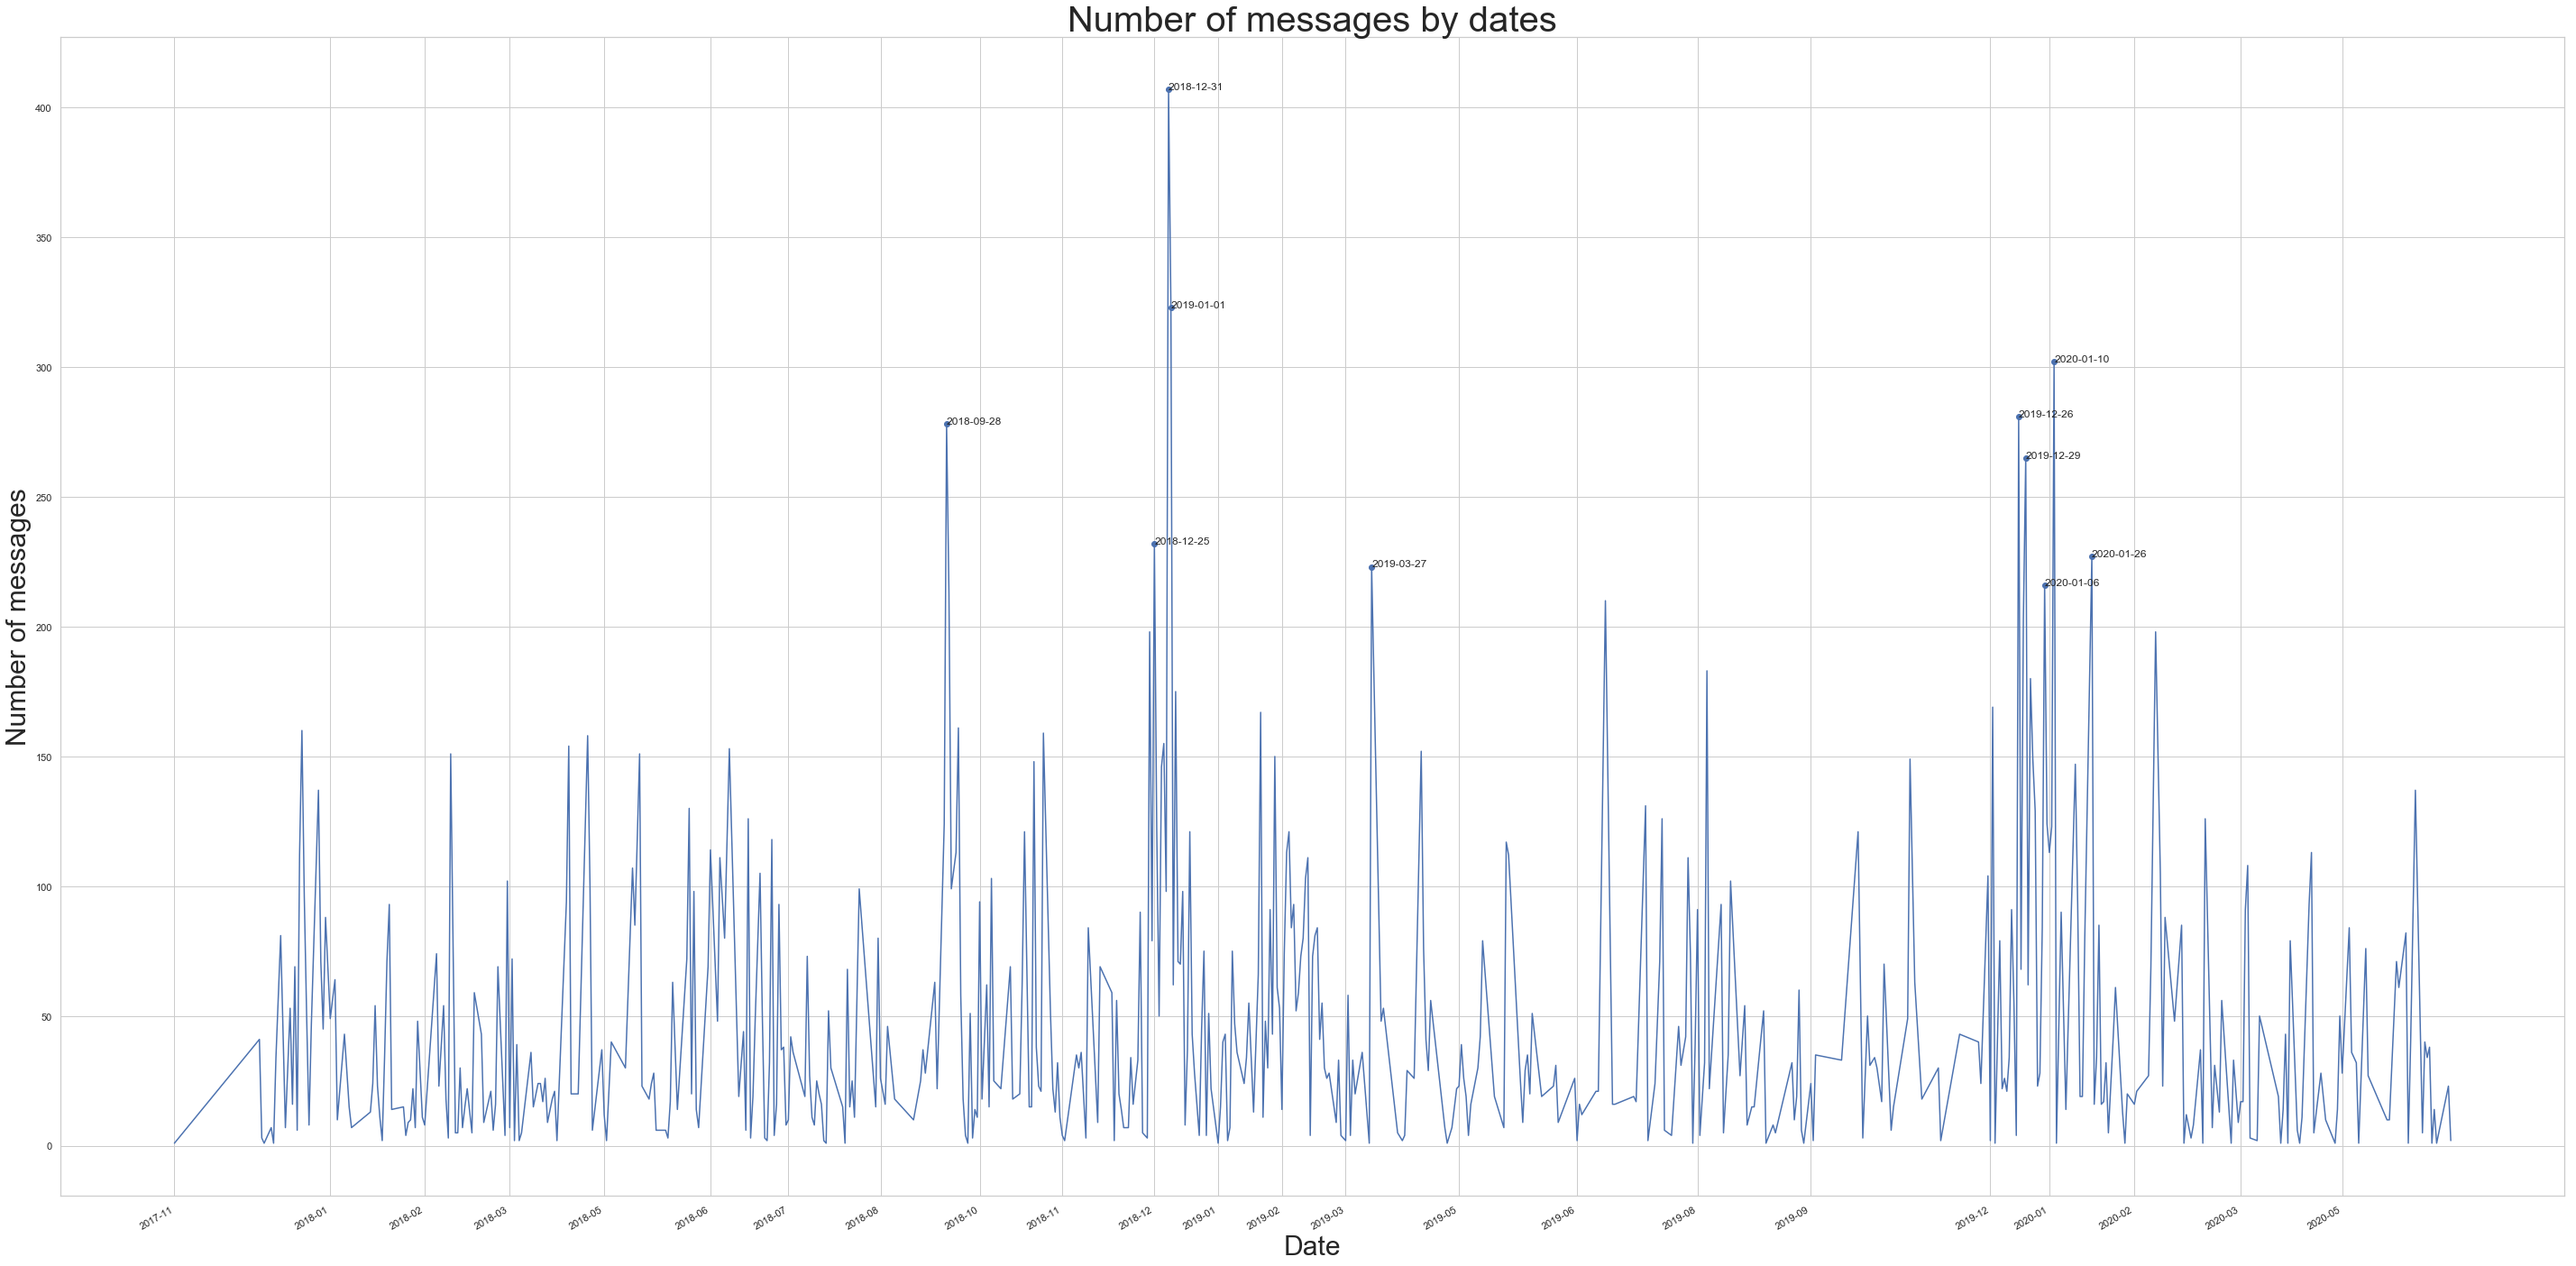

In [45]:
# To make a lineplot showing the number of messages for each day
sns.lineplot(data = no_of_messages_bydate, x = "Date", y = "Number_of_messages").set(xticks = no_of_messages_bydate.Date[::24])

# To plot the top 10 days using a blue dot
for x, y in sorted_no_of_messages.iloc[:10].values:
    plt.plot(x,y, "bo")
    plt.annotate(s = x, xy = (x,y))


plt.title("Number of messages by dates", fontsize = 40)
plt.ylabel("Number of messages", fontsize = 30)
plt.xlabel("Date", fontsize = 30)
sns.set(style = "whitegrid", font_scale = 1.5)
plt.gcf().autofmt_xdate()
plt.tight_layout(rect = (0,0,7,5))
plt.savefig("Number of chats by dates.png", format = "png", bbox_inches = "tight")
plt.show()

## Number of messages by year, month and weekday
Let's group our chats by year, month and weekday to see the distribution of messages.

In [46]:
month_year_chat_frame = chat_frame.copy()

month_year_chat_frame["Weekday"] = month_year_chat_frame["Date"].apply(lambda x:x.ctime()[:3])

month_year_chat_frame["Month"] = month_year_chat_frame["Date"].apply(lambda x:x.ctime()[4:7])

month_year_chat_frame["Year"] = month_year_chat_frame["Date"].apply(lambda x:x.ctime()[-4:])

month_year_chat_frame.head()

,Datetime,Sender,Message,Emoji,Date,Weekday,Month,Year
0,2017-11-05 20:41:00,Dotshine,[],[👀],2017-11-05,Sun,Nov,2017
1,2017-12-11 20:35:00,Hadek,[hello],[],2017-12-11,Mon,Dec,2017
2,2017-12-11 20:36:00,Dotshine,[],"[👀, 👀, 👀]",2017-12-11,Mon,Dec,2017
3,2017-12-11 20:46:00,Hadek,[eye],[],2017-12-11,Mon,Dec,2017
4,2017-12-11 20:48:00,Dotshine,"[checking, see, really]",[],2017-12-11,Mon,Dec,2017


#### By year
I'll use a bar chart to display the number of messages sent in each year

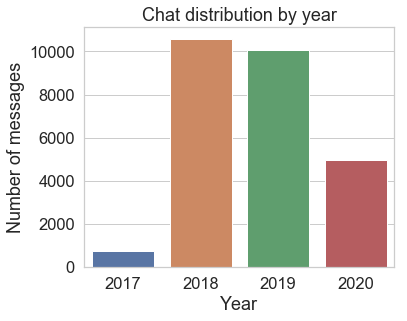

In [47]:
sns.countplot(x = "Year", data = month_year_chat_frame)
plt.ylabel("Number of messages")
plt.title("Chat distribution by year")
plt.tight_layout(rect = (0,0,1,1.2))

plt.savefig("Chat distribution by year.png", format = "png", bbox_inches = "tight")
plt.show()

This makes total sense. Since the chats in 2017 and 2020 are only for part of the years, it is totally normal that the numbers are nowhere near that of 2018 and 2019.

#### By Month
It is quite possible we chat more in some months. I'd like to see the number of messages we sent based on the months of the year.

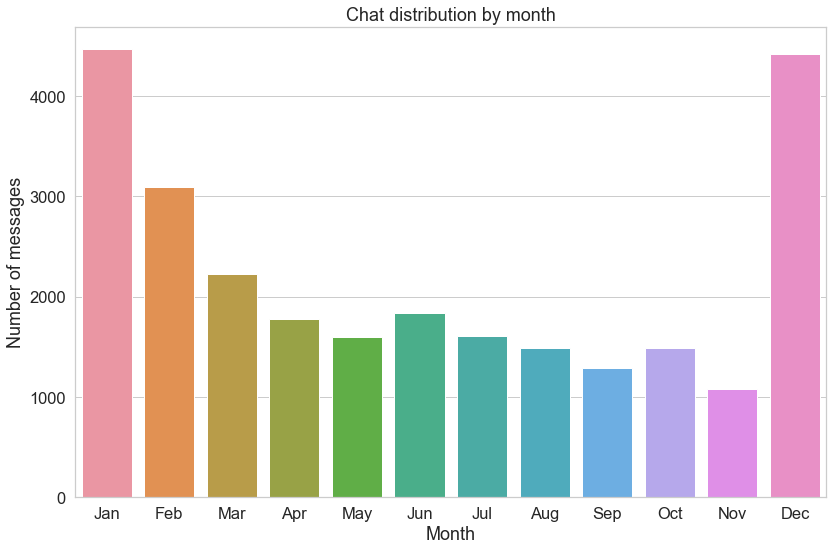

In [48]:
sns.countplot(x = "Month", data = month_year_chat_frame, order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.ylabel("Number of messages")
plt.title("Chat distribution by month")
plt.tight_layout(rect = (0,0,2,2))

plt.savefig("Chat distribution by month.png", format = "png", bbox_inches = "tight")
plt.show()

Turns out we send more messages in January and December. This is probably because we'd both be at home and be less busy with school work and other stuffs.

#### By year (Just 2018 and 2019)
I'll basically be doing the same thing I did above, except I'll be dropping the years 2017 and 2020. I'm dropping them because they only contain messages in some months.

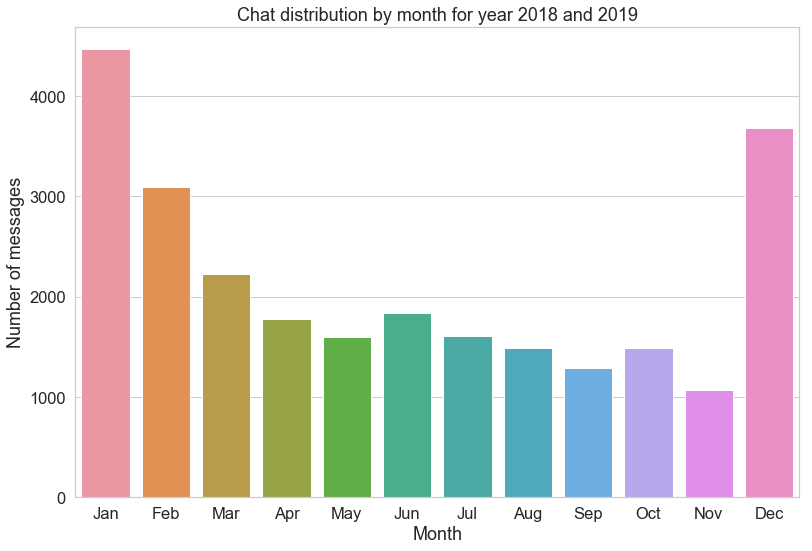

In [49]:
sns.countplot(x = "Month", data = month_year_chat_frame[(month_year_chat_frame["Year"] != "2020").any() and month_year_chat_frame["Year"] != "2017"])
plt.ylabel("Number of messages")
plt.title("Chat distribution by month for year 2018 and 2019")
plt.tight_layout(rect = (0,0,2,2))

plt.savefig("Chat distribution by month for year 2018 and 2019.png", format = "png", bbox_inches = "tight")
plt.show()

This doesn't seem to affect the outcome that much. Each month still retained their position: more messages were still sent in January and December, and the least is still in November.

#### For each month of active chat
Let's have bar chart that shows the number of messages sent in each month of active chat

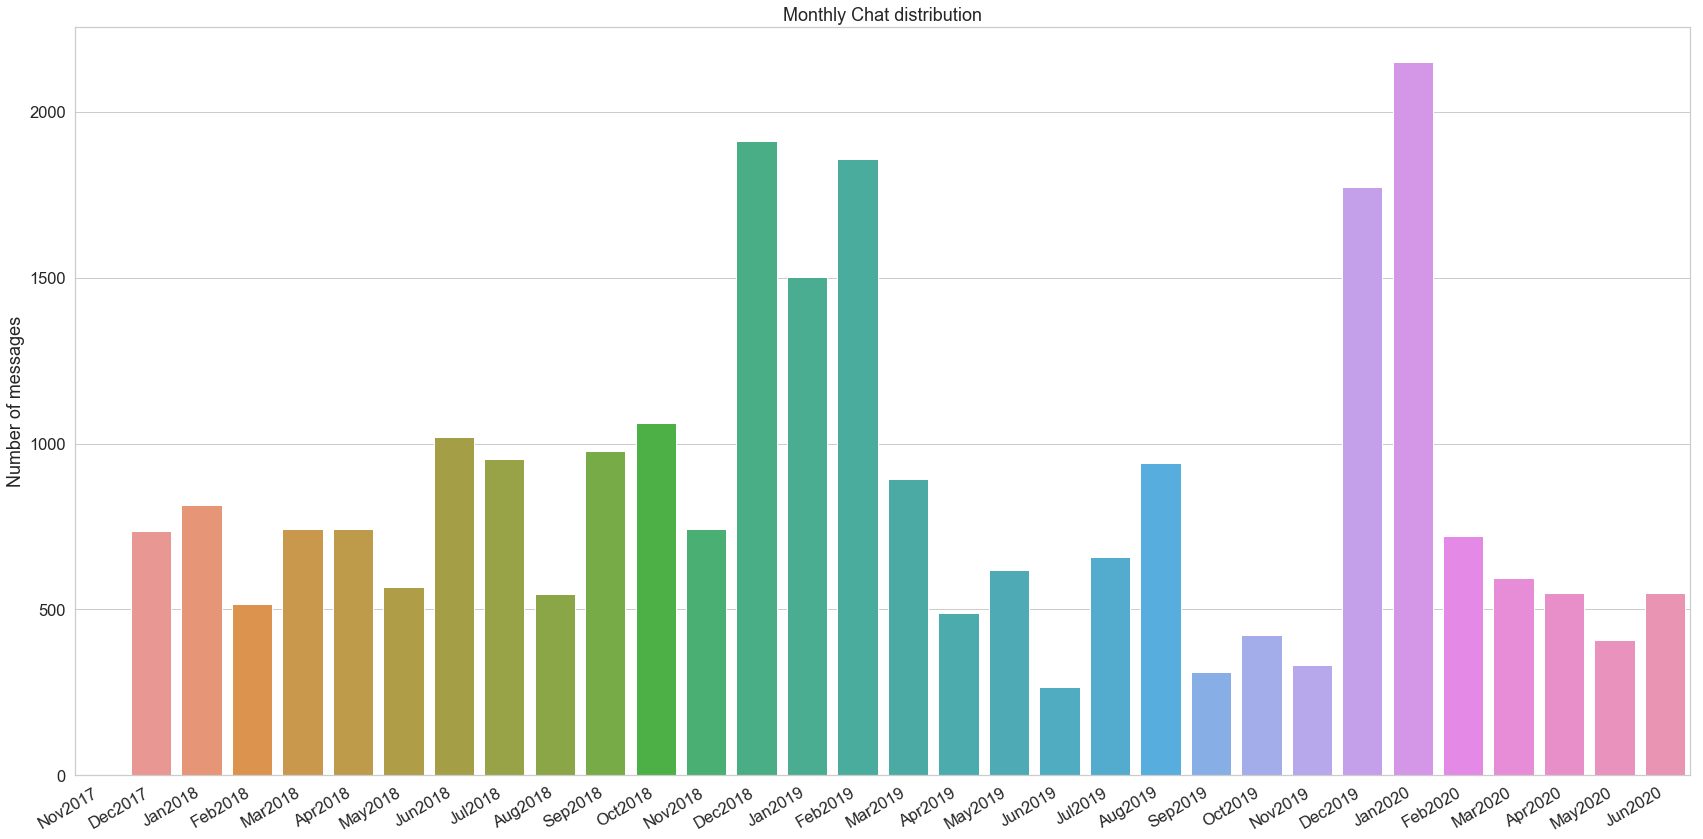

In [50]:
sns.countplot(month_year_chat_frame["Month"] + month_year_chat_frame["Year"])
plt.gcf().autofmt_xdate()

plt.ylabel("Number of messages")
plt.title("Monthly Chat distribution")

plt.tight_layout(rect = (0,0,4,3))

plt.savefig("Monthly Chat distribution.png", format = "png", bbox_inches = "tight")
plt.show()

#### By day of the week
Let's see what the chat distribution looks like based on the days of the week.

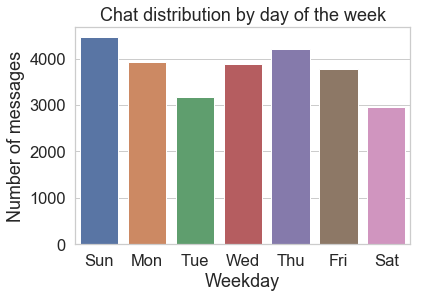

In [51]:
sns.countplot(x = "Weekday", data = month_year_chat_frame, order =["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])

plt.ylabel("Number of messages")
plt.title("Chat distribution by day of the week")

plt.savefig("Chat distribution by day of the week.png", format = "png", bbox_inches = "tight")
plt.show()

### What time are most active?
Let's see what the numbers of our chats look like throughout the hours of the day

In [52]:
# Function to convert datetime to time in hours
def datetime_to_time(datetime):
    return datetime.hour+datetime.minute/60

chat_frame["Time"] = chat_frame["Datetime"].apply(datetime_to_time)

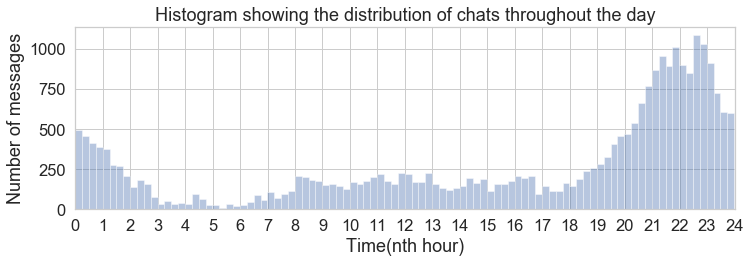

In [53]:
sns.distplot(chat_frame["Time"], bins = 96, kde = False).set(xticks = range(25), xlim = (0,24))
plt.title("Histogram showing the distribution of chats throughout the day")
plt.xlabel("Time(nth hour)")
plt.ylabel("Number of messages")
plt.tight_layout(rect = (0,0,2,1))

plt.savefig("Histogram showing the distribution of chats throughout the day.png", format = "png", bbox_inches = "tight")
plt.show()

Seems we are most active at night. The number of messages peaked around 11pm. 

#### Who sent the most media?
Let's see who sent the most media, including stickers.

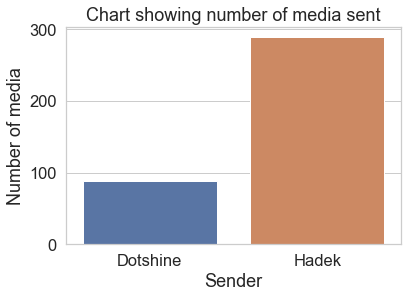

In [54]:
sns.countplot(chat_frame_or[chat_frame_or["Message"]=="<Media omitted> "]["Sender"])
plt.ylabel("Number of media")
plt.title("Chart showing number of media sent")

plt.savefig("Chart showing number of media sent.png", format = "png", bbox_inches = "tight")
plt.show()

#### Who deleted messages the most?

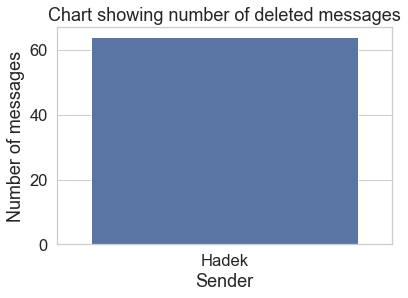

In [55]:
sns.countplot(chat_frame_or[chat_frame_or["Message"]=="This message was deleted "]["Sender"])

plt.ylabel("Number of messages")
plt.title("Chart showing number of deleted messages")

plt.savefig("Chart showing number of deleted messages.png", format = "png", bbox_inches = "tight")
plt.show()

Turns out I didn't delete any message. That's probably because I hardly ever delete messages unless it contains media.